In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
%matplotlib inline

In [2]:
random_state = 2018

In [3]:
np.random.seed(random_state)

In [4]:
def generate_test_predictions(clf, clf_name, pca_components=150, random_state=2018):
    data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)
    test_data = pd.read_csv('./data/test.csv', low_memory=False, skiprows=0)
    images = data.loc[:, data.columns != "label"].values
    labels = data["label"].values
    
    # PCA
    pca = PCA(n_components=pca_components, random_state=random_state)
    pca.fit(images)
    X_train_pca = pca.fit_transform(images)
    X_test_pca = pca.fit_transform(test_data)
    y_train = labels
    
    # Train classifier
    clf.fit(X_train_pca,y_train)

    # Generate test predictions    
    y_pred = clf.predict(X_test_pca)
    
    
    # Write test predictions into a file
    ImageId=list(range(1,test_data.shape[0]+1))
    results = np.column_stack((ImageId,y_pred))
    np.savetxt("%s_predictions.csv" % (clf_name),results,fmt='%i,%i',header='ImageId,Label',comments='')

# Read data

In [5]:
data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)

In [6]:
images = data.loc[:, data.columns != "label"].values
labels = data["label"].values
n_classes = 10
labels_text = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

print("Dimensionality of images: {}".format(images.shape))
print("Dimensionality of labels: {}".format(labels.shape))

Dimensionality of images: (42000, 784)
Dimensionality of labels: (42000,)


# Data visualization

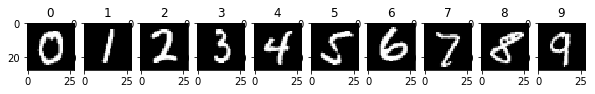

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

# Split data into train and test set 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels)

# PCA before performing any kind of classification

In [9]:
experiment_id = mlflow.create_experiment("PCA")
print("Experiment id: %d" % experiment_id)

Experiment id: 1


In [10]:
from sklearn.decomposition import PCA

number_of_features = images.shape[1]
desired_variance_captured = 0.95

# Find a good enough number of PCA components
with mlflow.start_run(experiment_id=experiment_id):
    pca = PCA(n_components=number_of_features, random_state=random_state)
    pca_fit = pca.fit(X_train)
    cumsum = np.cumsum(pca_fit.explained_variance_ratio_)
    pca_components = np.argmax(cumsum >= desired_variance_captured) + 1
    
    # Log params
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("initial pca_components", number_of_features)
    mlflow.log_param("variance captured", desired_variance_captured)
    
    mlflow.log_metric("calculated pca_components", pca_components)

In [11]:
print("Optimal number of PCA components: %s" % pca_components)

Optimal number of PCA components: 153


In [12]:
pca = PCA(n_components=pca_components, random_state=random_state)
pca_fit = pca.fit(X_train)

X_train_pca = pca_fit.transform(X_train)
X_test_pca = pca_fit.transform(X_test)

# RandomForestClassifier

In [13]:
experiment_id = mlflow.create_experiment("RandomForestClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 2


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 100
cv = 7
criterion = "gini"

with mlflow.start_run(experiment_id=experiment_id):
    
    # Cross validation
    clf = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, random_state=random_state, n_jobs=-1)
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    #Test 
    clf.fit(X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 0.9419 (+/- 0.0063)
Accuracy on test set: 0.9364


## Generate test predictions

In [15]:
clf = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, random_state=random_state, n_jobs=-1)

generate_test_predictions(clf, "RandomForestClassifier", pca_components=pca_components, random_state=random_state)

# GridSearchCV with RandomForestClassifier

** Please note that this step is very slow, since it has to try all posible combinations described in *param_grid* **

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
cv = 3

param_grid = {
    "n_estimators" : [10, 20, 50, 100, 300],
    "criterion" : ["gini", "entropy"],
    "max_features" : [pca_components, "auto", "log2", "sqrt"],
    "max_depth" : [5,10,20,None],
    "random_state": [random_state]
}

param_grid = {
    "n_estimators" : [10, 20],
    "criterion" : ["entropy"],
    "max_features" : ["auto"],
    "max_depth" : [None],
    "random_state": [random_state]
}

gridSearch = GridSearchCV(estimator=estimator, scoring='accuracy', param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)

gridSearch.fit(X_train_pca, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   45.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'random_state': [2018], 'max_features': ['auto'], 'max_depth': [None], 'n_estimators': [10, 20], 'criterion': ['entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [17]:
experiment_id = mlflow.create_experiment("GridSearchCV using RF")
print("Experiment id: %d" % experiment_id)

Experiment id: 3


In [18]:
for score in gridSearch.grid_scores_:
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("cv", cv)
        mlflow.log_param("pca_components", pca_components)
        mlflow.log_param("random_state", random_state)

        n_estimators = score.parameters["n_estimators"]
        criterion = score.parameters["criterion"]
        max_features = score.parameters["max_features"]
        max_depth = score.parameters["max_depth"]
        cv_accuracy = score.mean_validation_score

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("criterion", criterion)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("max_depth", max_depth)

        mlflow.log_metric("cv_accuracy", cv_accuracy) 

## Generate test predictions

In [19]:
clf = gridSearch.best_estimator_
generate_test_predictions(clf, "GridSearch+RandomForestClassifier", pca_components=pca_components, random_state=random_state)

# LDA

In [20]:
experiment_id = mlflow.create_experiment("LDA")
print("Experiment id: %d" % experiment_id)

Experiment id: 4


In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

cv = 7
solver = "svd"
shrinkage=None
tol=0.0001

with mlflow.start_run(experiment_id=experiment_id):

    # Cross-Validation
    clf = LDA(solver=solver, shrinkage=shrinkage, tol=tol)
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    # Test
    clf.fit(X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("cv", cv)
    
    mlflow.log_param("solver", solver)
    mlflow.log_param("shrinkage", shrinkage)
    mlflow.log_param("tol", tol)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy on cross-validation set: 0.8683 (+/- 0.0100)
Accuracy on test set: 0.8643


## Generate test predictions

In [22]:
clf = LDA(solver=solver, shrinkage=shrinkage, tol=tol)
generate_test_predictions(clf, "LDA", pca_components=pca_components, random_state=random_state)

# GradientBoostingClassifier with PCA

In [23]:
experiment_id = mlflow.create_experiment("GradientBoostingClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 5


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 12
cv = 7
max_depth = 3

with mlflow.start_run(experiment_id=experiment_id):
    
    # Cross-Validation
    clf = GradientBoostingClassifier(n_estimators=n_trees,random_state=random_state, max_depth=max_depth)
    
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    # Test
    clf.fit(X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 0.8064 (+/- 0.0064)
Accuracy on test set: 0.7998


## Generate test predictions

In [25]:
clf = GradientBoostingClassifier(n_estimators=n_trees,random_state=random_state, max_depth=max_depth)
generate_test_predictions(clf, "GradientBoostingClassifier", pca_components=pca_components, random_state=random_state)